In [5]:
#Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
import math
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import pickle
import shutil

In [7]:
#Connecting to GitHub
!git clone https://github.com/robertsarnet/IDS-project.git
%cd IDS-project/IDS_data
!dir

[WinError 2] The system cannot find the file specified: 'IDS-project/IDS_data'
c:\Users\rober.DESKTOP-ASC95IC\Downloads\IDS-project\IDS_data


fatal: destination path 'IDS-project' already exists and is not an empty directory.


 Volume in drive C has no label.
 Volume Serial Number is B4C1-16F0

 Directory of c:\Users\rober.DESKTOP-ASC95IC\Downloads\IDS-project\IDS_data

16/12/2024  09:22    <DIR>          .
16/12/2024  08:18    <DIR>          ..
16/12/2024  09:22    <DIR>          IDS-project
15/12/2024  23:09             6,839 label_encoder_all.pkl
16/12/2024  09:19               495 label_encoder_Apple.pkl
16/12/2024  09:19               348 label_encoder_Cherry_(including_sour).pkl
16/12/2024  09:19               799 label_encoder_Corn_(maize).pkl
16/12/2024  09:19               783 label_encoder_Grape.pkl
16/12/2024  09:19               348 label_encoder_Peach.pkl
16/12/2024  09:19               348 label_encoder_Pepper,_bell.pkl
16/12/2024  09:19               380 label_encoder_Potato.pkl
16/12/2024  09:10             1,067 label_encoder_species.pkl
16/12/2024  09:19               324 label_encoder_Strawberry.pkl
16/12/2024  09:19             1,679 label_encoder_Tomato.pkl
15/12/2024  08:12       178,16

In [8]:
#Specifying folders
train_folder = "train"
val_folder = "valid"
test_folder = "test"

In [9]:
# Loading in previously trained and saved models and encoders
model_species = load_model('model_species.keras')
with open("label_encoder_species.pkl", 'rb') as file:
    label_encoder_species = pickle.load(file)

# Dictionary to hold disease-specific models and encoders
disease_models_encoders = {}

# List of species and corresponding file names
species_files = {
    "Tomato": ("model_Tomato.keras", "label_encoder_Tomato.pkl"),
    "Potato": ("model_Potato.keras", "label_encoder_Potato.pkl"),
    "Apple": ("model_Apple.keras", "label_encoder_Apple.pkl"),
    "Grape": ("model_Grape.keras", "label_encoder_Grape.pkl"),
    "Peach": ("model_Peach.keras", "label_encoder_Peach.pkl"),
    "Cherry_(including_sour)": ("model_Cherry_(including_sour).keras", "label_encoder_Cherry_(including_sour).pkl"),
    "Corn_(maize)": ("model_Corn_(maize).keras", "label_encoder_Corn_(maize).pkl"),
    "Pepper,_bell": ("model_Pepper,_bell.keras", "label_encoder_Pepper,_bell.pkl"),
    "Strawberry": ("model_Strawberry.keras", "label_encoder_Strawberry.pkl")
}

# Load disease-specific models and encoders
for species, (model_file, encoder_file) in species_files.items():
    with open(encoder_file, 'rb') as file:
        label_encoder = pickle.load(file)
    disease_models_encoders[species] = [load_model(model_file), label_encoder]

# Load the 'all' model and encoder
model_all = load_model("model_all.keras")
with open("label_encoder_all.pkl", 'rb') as file:
    label_encoder_all = pickle.load(file)

# Check the loaded encoders
print(disease_models_encoders)


{'Tomato': [<Sequential name=sequential_9, built=True>, LabelEncoder()], 'Potato': [<Sequential name=sequential_7, built=True>, LabelEncoder()], 'Apple': [<Sequential name=sequential_1, built=True>, LabelEncoder()], 'Grape': [<Sequential name=sequential_4, built=True>, LabelEncoder()], 'Peach': [<Sequential name=sequential_5, built=True>, LabelEncoder()], 'Cherry_(including_sour)': [<Sequential name=sequential_2, built=True>, LabelEncoder()], 'Corn_(maize)': [<Sequential name=sequential_3, built=True>, LabelEncoder()], 'Pepper,_bell': [<Sequential name=sequential_6, built=True>, LabelEncoder()], 'Strawberry': [<Sequential name=sequential_8, built=True>, LabelEncoder()]}


In [10]:
diseases = {}

# Collect image paths and labels from all subfolders
for imfolder in os.listdir(train_folder): #Go through all folders in the train folder (each folder represents a category)
    folder_path = os.path.join(train_folder, imfolder)
    if os.path.isdir(folder_path):
        if imfolder.strip().split("___")[0] not in diseases:
            diseases[imfolder.strip().split("___")[0]] = [imfolder.strip().split("___")[1]]
        if imfolder.strip().split("___")[1] not in diseases[imfolder.strip().split("___")[0]]:
             diseases[imfolder.strip().split("___")[0]].append(imfolder.strip().split("___")[1])

print(diseases)

{'Apple': ['Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'healthy'], 'Cherry_(including_sour)': ['healthy', 'Powdery_mildew'], 'Corn_(maize)': ['Cercospora_leaf_spot Gray_leaf_spot', 'Common_rust_', 'healthy', 'Northern_Leaf_Blight'], 'Grape': ['Black_rot', 'Esca_(Black_Measles)', 'healthy', 'Leaf_blight_(Isariopsis_Leaf_Spot)'], 'Peach': ['Bacterial_spot', 'healthy'], 'Pepper,_bell': ['Bacterial_spot', 'healthy'], 'Potato': ['Early_blight', 'healthy', 'Late_blight'], 'Strawberry': ['healthy', 'Leaf_scorch'], 'Tomato': ['Bacterial_spot', 'Early_blight', 'healthy', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_mosaic_virus', 'Tomato_Yellow_Leaf_Curl_Virus']}


In [12]:
image_paths = [] #collecting all image paths to a list
species_labels = [] #collecting all species labels of the images to a list (as strings, extracted from file names)
disease_labels = []

for imfolder in os.listdir(test_folder): #Go through all subfolders in the specified (train/validation/test) folder (each subfolder represents a category)
    folder_path = os.path.join(test_folder, imfolder)
    if os.path.isdir(folder_path):
        for imfile in os.listdir(folder_path): #Go through all of the files (photos) in the subfolder
            image_path = os.path.join(folder_path, imfile)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                species_labels.append(imfolder.strip().split("___")[0])
                disease_labels.append(imfolder.strip().split("___")[1])


random.seed(7)

# To shuffle the data by shuffling the indexes
indices = list(range(len(image_paths)))
random.shuffle(indices)

In [13]:
def image_data_species(paths, labels, indices, batch_size=32, encoder = label_encoder_species):
    while True:
        # Yield data in batches
        X_batch = []
        y_batch = []

        for i in indices:
            image_path = paths[i]
            label = labels[i]

            img = cv2.imread(image_path) #Load in the image data (256x256x3 matrix) with cv2

            if img is not None:
                if img.shape != (256, 256, 3):
                    img = cv2.resize(img, (256, 256)) #If an image doesnt have the regular size, resize it
                img = img / 255.0  # Normalize the image to the range [0, 1], because neural networks work better with numbers in this range

                X_batch.append(img)
                y_batch.append(label)

            # Full batch
            if len(X_batch) >= batch_size:
                X_batch = np.array(X_batch) #Convert to numpy array
                y_batch = encoder.transform(y_batch)  #Convert string labels to integers
                y_batch = np.array(y_batch)

                yield X_batch, y_batch

                X_batch = []
                y_batch = []

    #All remaining images that aren't part of a full batch
        if X_batch:
            X_batch = np.array(X_batch)
            y_batch = encoder.transform(y_batch)
            y_batch = np.array(y_batch)

            yield X_batch, y_batch

In [14]:
test_data_species = image_data_species(image_paths, species_labels, indices, 32, label_encoder_species)
test_steps_species = int(math.ceil(len(image_paths) / 32))

#Evaluating model accuracy on testset
test_loss, test_accuracy = model_species.evaluate(
    test_data_species,
    steps=test_steps_species,
    verbose=1
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.2%}") #Total test accuracy on all images

237/237 ━━━━━━━━━━━━━━━━━━━━ 69s 287ms/step - accuracy: 0.9434 - loss: 0.1821
Test Loss: 0.1709437519311905
Test Accuracy: 94.60%


Cloning into 'IDS-project'...
Updating files:   1% (1464/76195)
Updating files:   2% (1524/76195)
Updating files:   3% (2286/76195)
Updating files:   3% (2885/76195)
Updating files:   4% (3048/76195)
Updating files:   5% (3810/76195)
Updating files:   5% (4377/76195)
Updating files:   6% (4572/76195)
Updating files:   7% (5334/76195)
Updating files:   7% (6021/76195)
Updating files:   8% (6096/76195)
Updating files:   9% (6858/76195)
Updating files:   9% (7470/76195)
Updating files:  10% (7620/76195)
Updating files:  11% (8382/76195)
Updating files:  11% (8684/76195)
Updating files:  12% (9144/76195)
Updating files:  13% (9906/76195)
Updating files:  13% (9993/76195)
Updating files:  14% (10668/76195)
Updating files:  14% (11368/76195)
Updating files:  15% (11430/76195)
Updating files:  16% (12192/76195)
Updating files:  16% (12904/76195)
Updating files:  17% (12954/76195)
Updating files:  18% (13716/76195)
Updating files:  18% (14206/76195)
Updating files:  19% (14478/76195)
Updating 

In [60]:
all_predictions_species = []
all_true_labels_species = []

for _ in range(test_steps_species):
    try:
        # Get a batch of test images and labels
        test_images, test_labels = next(test_data_species)

        # Predict the labels for the test images
        predictions = model_species.predict(test_images)

        # Convert predicted probabilities to class indices
        predicted_classes = np.argmax(predictions, axis=1)
        all_predictions_species.extend(predicted_classes)
        all_true_labels_species.extend(test_labels)
    except StopIteration:
        break  # Exit if the generator is exhausted



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
unique = list(set(all_true_labels_species))

accuracies_species = {}

for species in unique:
    comparison_species = []
    for i in range(len(all_true_labels_species)):
        if all_true_labels_species[i] == species:
                correct_species = all_true_labels_species[i] == all_predictions_species[i]
                comparison_species.append(correct_species)
    comparison_species = np.array(comparison_species)
    accuracy_species = np.mean(comparison_species)
    accuracies_species[label_encoder_species.inverse_transform([species])[0]] = f"{accuracy_species: .2%}"


# Evaluate the accuracy of predictions
accuracy = np.mean(np.array(all_predictions_species) == np.array(all_true_labels_species))

accuracies_species["All"] = f"{accuracy: .2%}"

print(accuracies_species)


{'Apple': ' 90.73%', 'Cherry_(including_sour)': ' 85.19%', 'Corn_(maize)': ' 99.54%', 'Grape': ' 99.00%', 'Peach': ' 87.67%', 'Pepper,_bell': ' 92.97%', 'Potato': ' 94.63%', 'Strawberry': ' 98.88%', 'Tomato': ' 95.24%', 'All': ' 94.60%'}


In [54]:
accuracies_species_updated = {}
for key, value in accuracies_species.items():
    accuracies_species_updated[key.split("_")[0].strip(",")] = round(float(value.strip('%'))/100, 2)

print(accuracies_species_updated)


{'Apple': 0.91, 'Cherry': 0.85, 'Corn': 1.0, 'Grape': 0.99, 'Peach': 0.88, 'Pepper': 0.93, 'Potato': 0.95, 'Strawberry': 0.99, 'Tomato': 0.95, 'All': 0.95}


In [17]:
def image_data_disease(folder, species, batch_size=32):
    image_paths = []
    disease_labels = []

    for imfolder in os.listdir(folder): #Go through all folders in the train folder (each folder represents a category)
        folder_path = os.path.join(folder, imfolder)
        if os.path.isdir(folder_path):
            species_name, disease_name = imfolder.strip().split("___")
            if species_name == species:
              for imfile in os.listdir(folder_path): #Go through all of the files (photos) in the subfolder
                  image_path = os.path.join(folder_path, imfile)
                  if os.path.isfile(image_path):
                      image_paths.append(image_path)
                      disease_labels.append(disease_name)

    unique_labels = list(set(disease_labels))

    label_encoder_disease = disease_models_encoders[species][1]


    def generator(seed=None):
        if seed is None:
            random.seed(7)

        # Shuffle the data by shuffling the indexes
        indices = list(range(len(image_paths)))
        random.shuffle(indices)

        while True:
            # Yield data in batches
            X_batch = []
            y_batch = []

            for i in indices:
                image_path = image_paths[i]
                label = disease_labels[i]

                img = cv2.imread(image_path) #Load in the image data (256x256x3 matrix) with cv2

                if img is not None:
                    if img.shape != (256, 256, 3):
                        img = cv2.resize(img, (256, 256)) #If an image doesnt have the regular size, resize it
                    img = img / 255.0  # Normalize the image to the range [0, 1], because neural networks work better with numbers in this range

                    X_batch.append(img)
                    y_batch.append(label)

                # Full batch
                if len(X_batch) >= batch_size:
                    X_batch = np.array(X_batch) #Convert to numpy array

                    y_batch = label_encoder_disease.transform(y_batch)  #Convert string labels to integers
                    y_batch = np.array(y_batch)


                    yield X_batch, y_batch

                    X_batch = []
                    y_batch = []

        #All remaining images that aren't part of a full batch
            if X_batch:
                X_batch = np.array(X_batch) #Convert to numpy array

                y_batch = label_encoder_disease.transform(y_batch)  #Convert string labels to integers
                y_batch = np.array(y_batch)

                yield X_batch, y_batch

    return generator(seed=7), image_paths, label_encoder_disease, unique_labels

In [30]:
species_names = []
test_losses = []
accuracies_disease_known_species = {}

for i, (species, disease) in enumerate(diseases.items()):
    print(species, len(disease))
    print(disease)
    test_data_disease, image_paths_test_disease, _, labels = image_data_disease(test_folder, species, 32)
    test_steps_disease = int(math.ceil(len(image_paths_test_disease) / 32))

    test_loss, test_accuracy = disease_models_encoders[species][0].evaluate(
        test_data_disease,
        steps=test_steps_disease,
        verbose=1
    )

    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy:.2%}\n")

    species_names.append(species)
    test_losses.append(test_loss)
    accuracies_disease_known_species[species] = f"{test_accuracy:.2%}"

print(accuracies_disease_known_species)

Apple 4
['Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'healthy']
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.9622 - loss: 0.1183
Test Loss: 0.13442634046077728
Test Accuracy: 95.93%

Cherry_(including_sour) 2
['healthy', 'Powdery_mildew']
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.9972 - loss: 0.0224
Test Loss: 0.07522937655448914
Test Accuracy: 99.54%

Corn_(maize) 4
['Cercospora_leaf_spot Gray_leaf_spot', 'Common_rust_', 'healthy', 'Northern_Leaf_Blight']
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.9628 - loss: 0.1569
Test Loss: 0.1798344850540161
Test Accuracy: 96.35%

Grape 4
['Black_rot', 'Esca_(Black_Measles)', 'healthy', 'Leaf_blight_(Isariopsis_Leaf_Spot)']
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.9725 - loss: 0.0665
Test Loss: 0.0933799296617508
Test Accuracy: 96.23%

Peach 2
['Bacterial_spot', 'healthy']
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.9819 - loss: 0.0469
Test Loss: 0.062390509992837906
Test Accuracy: 97

In [41]:
mean_accuracy = sum(float(value.strip('%')) for value in accuracies_disease_known_species.values()) / len(accuracies_disease_known_species)

accuracies_disease_known_species["All"] = f"{round(mean_accuracy, 2)}%"

95.26111111111112
{'Apple': '95.93%', 'Cherry_(including_sour)': '99.54%', 'Corn_(maize)': '96.35%', 'Grape': '96.23%', 'Peach': '97.76%', 'Pepper,_bell': '90.25%', 'Potato': '94.21%', 'Strawberry': '99.33%', 'Tomato': '87.75%', 'All': '95.26%'}


In [52]:
accuracies_disease_known_species_updated = {}
for key, value in accuracies_disease_known_species.items():
    accuracies_disease_known_species_updated[key.split("_")[0].strip(",")] = round(float(value.strip('%'))/100,2)

print(accuracies_disease_known_species_updated)


{'Apple': 0.96, 'Cherry': 1.0, 'Corn': 0.96, 'Grape': 0.96, 'Peach': 0.98, 'Pepper': 0.9, 'Potato': 0.94, 'Strawberry': 0.99, 'Tomato': 0.88, 'All': 0.95}


In [19]:
random.seed(7)

indices = list(range(len(image_paths)))
random.shuffle(indices)

true_species = []
true_disease = []
prediction_species = []
prediction_diseases = []

all_predictions_species = []
all_true_labels_species = []

for i in indices:
    image_path = image_paths[i]
    label_species = species_labels[i]
    label_disease = disease_labels[i]
    true_species.append(label_species)
    true_disease.append(label_disease)

    img = cv2.imread(image_path) #Load in the image data (256x256x3 matrix) with cv2

    if img is not None:
        if img.shape != (256, 256, 3):
            img = cv2.resize(img, (256, 256)) #If an image doesnt have the regular size, resize it
        img = np.expand_dims(img, axis=0)
        img = img / 255.0  # Normalize the image to the range [0, 1], because neural networks work better with numbers in this range

    predicted_species = model_species.predict(img)
    predicted_species_class_index = np.argmax(predicted_species)
    decoded_label_species = label_encoder_species.inverse_transform([predicted_species_class_index])

    model = disease_models_encoders[decoded_label_species[0]][0]

    predicted_disease = model.predict(img)
    predicted_disease_class_index = np.argmax(predicted_disease)
    disease_label_encoder = disease_models_encoders[decoded_label_species[0]][1]
    decoded_label_disease = disease_label_encoder.inverse_transform([predicted_disease_class_index])
    prediction_species.append(decoded_label_species[0])
    prediction_diseases.append(decoded_label_disease[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━

{'All': 0.8868198626518753, 'Apple: Apple scab': 0.9019607843137255, 'Apple: Black rot': 0.8830645161290323, 'Apple: Cedar apple rust': 0.8777292576419214, 'Apple: healthy': 0.82, 'Cherry: healthy': 0.7533039647577092, 'Cherry: Powdery mildew': 0.9575471698113207, 'Corn: Cercospora leaf spot Gray leaf spot': 0.8333333333333334, 'Corn: Common rust ': 0.9958677685950413, 'Corn: healthy': 1.0, 'Corn: Northern Leaf Blight': 0.9747899159663865, 'Grape: Black rot': 0.9578059071729957, 'Grape: Esca (Black Measles)': 0.8870292887029289, 'Grape: healthy': 0.9906103286384976, 'Grape: Leaf blight (Isariopsis Leaf Spot)': 0.9813084112149533, 'Peach: Bacterial spot': 0.8608695652173913, 'Peach: healthy': 0.8703703703703703, 'Pepper,: Bacterial spot': 0.7458333333333333, 'Pepper,: healthy': 0.9402985074626866, 'Potato: Early blight': 0.9352226720647774, 'Potato: healthy': 0.8734177215189873, 'Potato: Late blight': 0.859504132231405, 'Strawberry: healthy': 1.0, 'Strawberry: Leaf scorch': 0.9634703196

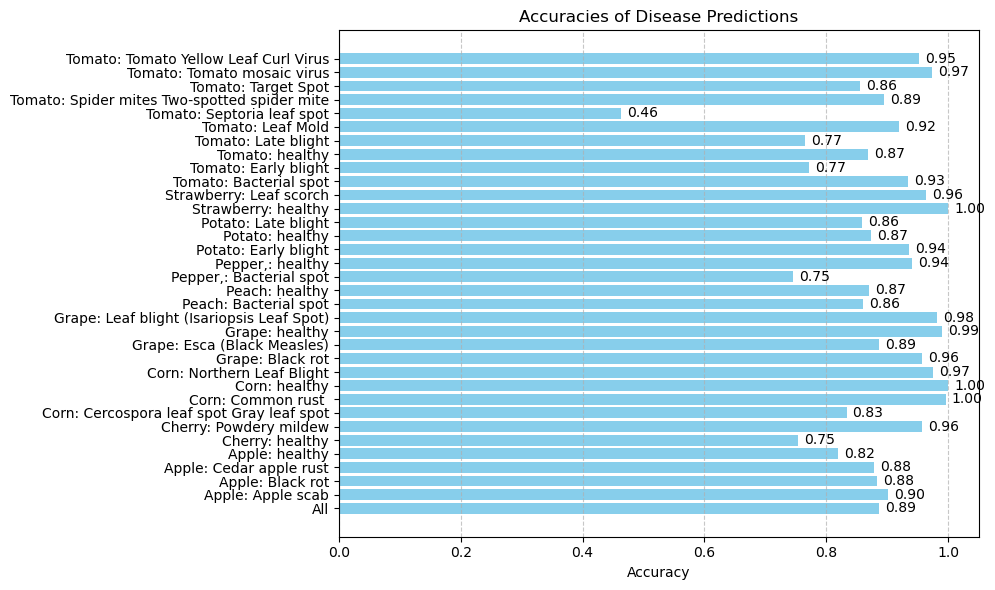

In [46]:
correct_species = np.array(true_species) == np.array(prediction_species)
correct_disease = np.array(true_disease) == np.array(prediction_diseases)
accuracy = np.mean(correct_species & correct_disease)

accuracies = {}
accuracies["All"] = accuracy
for species, disease_list in diseases.items():
    modified_species = species.split("_")[0].strip(";")
    for disease in disease_list:
        comparison_diseases = []
        comparison_species = []
        for i in range(len(true_species)):
            if true_species[i] == species:
                if true_disease[i] == disease:
                    correct_species = true_species[i] == prediction_species[i]
                    correct_disease = true_disease[i] == prediction_diseases[i]
                    comparison_species.append(correct_species)
                    comparison_diseases.append(correct_disease)
        comparison_species = np.array(comparison_species)
        comparison_diseases = np.array(comparison_diseases)
        accuracy_disease = np.mean(comparison_species & comparison_diseases)

        modified_disease = disease.replace("_", " ")
        joined_label = modified_species + ": " + modified_disease
        accuracies[joined_label] = accuracy_disease

print(accuracies)        

    
labels = list(accuracies.keys())
values = list(accuracies.values())

# Plot the data
plt.figure(figsize=(10, 6))  
bars = plt.barh(labels, values, color='skyblue')  

plt.xlabel('Accuracy')
plt.title('Accuracies of Disease Predictions')

plt.grid(axis='x', linestyle='--', alpha=0.7)

# Annotate values on each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.01,  
        bar.get_y() + bar.get_height() / 2,  
        f'{width:.2f}',  
        ha='left',  
        va='center',  
        fontsize=10,  
        color='black'  
    )

# Show the plot
plt.tight_layout() 
plt.show()


{'Apple': 0.87, 'Cherry': 0.85, 'Corn': 0.96, 'Grape': 0.95, 'Peach': 0.87, 'Pepper,': 0.83, 'Potato': 0.89, 'Strawberry': 0.98, 'Tomato': 0.84, 'All': 0.89}


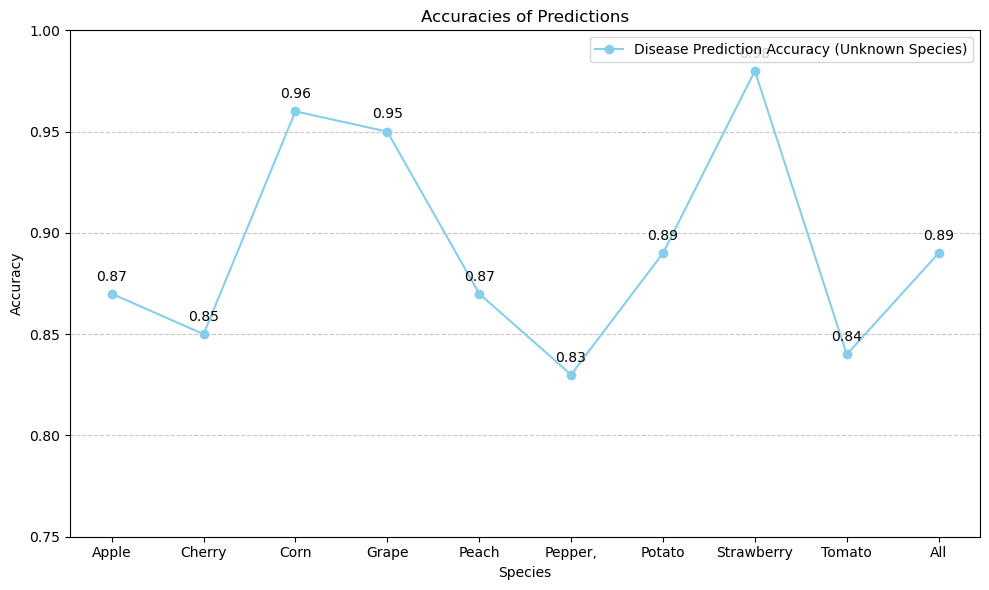

In [ ]:
#Create a dictionary with accuracies
accuracies = {}
for species, disease_list in diseases.items():
    modified_species = species.split("_")[0].strip(";")
    comparison_diseases = []
    comparison_species = []
    for i in range(len(true_species)):
        if true_species[i] == species:
            if true_disease[i] in disease_list:
                correct_species = true_species[i] == prediction_species[i]
                correct_disease = true_disease[i] == prediction_diseases[i]
                comparison_species.append(correct_species)
                comparison_diseases.append(correct_disease)
    comparison_species = np.array(comparison_species)
    comparison_diseases = np.array(comparison_diseases)
    accuracy_disease = np.mean(comparison_species & comparison_diseases)

    modified_disease = disease.replace("_", " ")
    joined_label = modified_species + ": " + modified_disease
    accuracies[modified_species] = round(accuracy_disease, 2)

accuracies["All"] = round(accuracy, 2)
print(accuracies)   
labels = list(accuracies.keys())
values = list(accuracies.values())

# Plot the data
plt.figure(figsize=(10, 6)) 
plt.plot(labels, values, marker='o', color='skyblue', label='Disease Prediction Accuracy (Unknown Species)')
plt.ylabel('Accuracy')
plt.xlabel('Species')
plt.title('Accuracies of Predictions')
plt.ylim(0.75, 1.0)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 

for i, value in enumerate(values):
    plt.text(
        i, value + 0.005, 
        f'{value:.2f}', 
        ha='center', 
        va='bottom',  
        fontsize=10,  
        color='black' 
    )

plt.legend()
plt.tight_layout()  
plt.show()


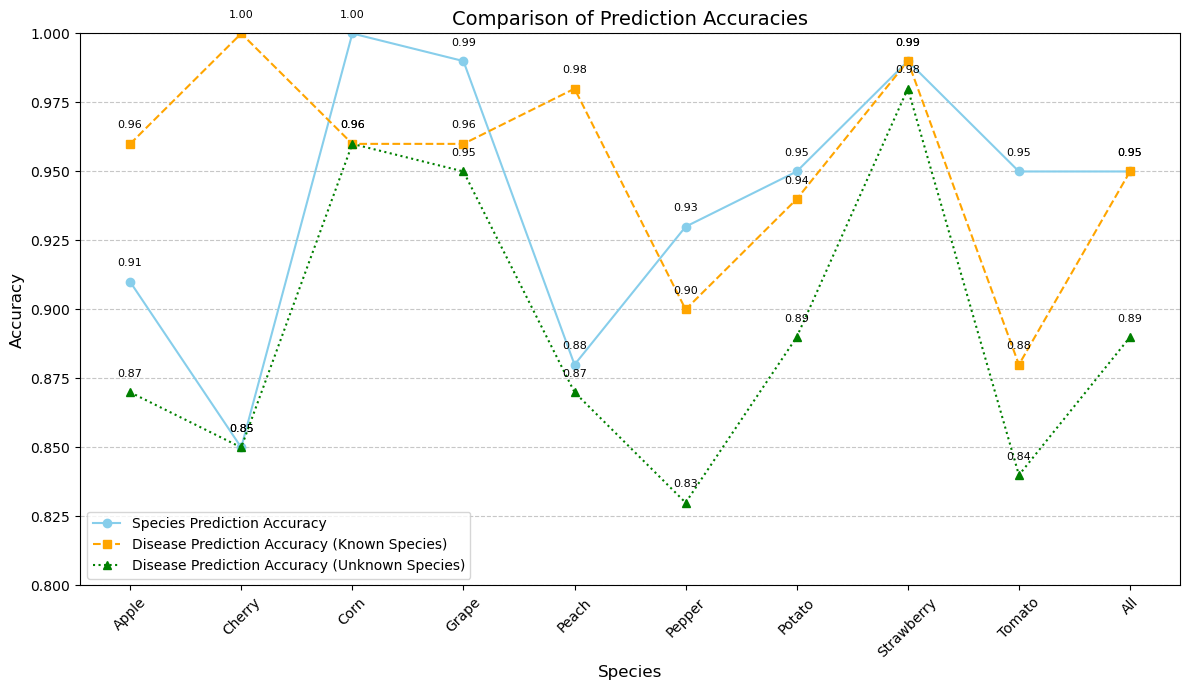

In [ ]:
categories = list(accuracies_species_updated.keys())
values_species_updated = list(accuracies_species_updated.values())
values_disease_known_species_updated = list(accuracies_disease_known_species_updated.values())
values_accuracies = list(accuracies.values())

# Plotting
plt.figure(figsize=(12, 7))

plt.plot(categories, values_species_updated, marker='o', color='skyblue', label='Species Prediction Accuracy')
for i, value in enumerate(values_species_updated):
    plt.text(i, value + 0.005, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.plot(categories, values_disease_known_species_updated, marker='s', color='orange', label='Disease Prediction Accuracy (Known Species)', linestyle='--')
for i, value in enumerate(values_disease_known_species_updated):
    plt.text(i, value + 0.005, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.plot(categories, values_accuracies, marker='^', color='green', label='Disease Prediction Accuracy (Unknown Species)', linestyle=':')
for i, value in enumerate(values_accuracies):
    plt.text(i, value + 0.005, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

# Customize the graph
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Species', fontsize=12)
plt.title('Comparison of Prediction Accuracies', fontsize=14)
plt.ylim(0.8, 1.0) 
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()

plot_filename = "accuracy_comparison_plot.png"
plt.savefig(plot_filename)

plt.show()



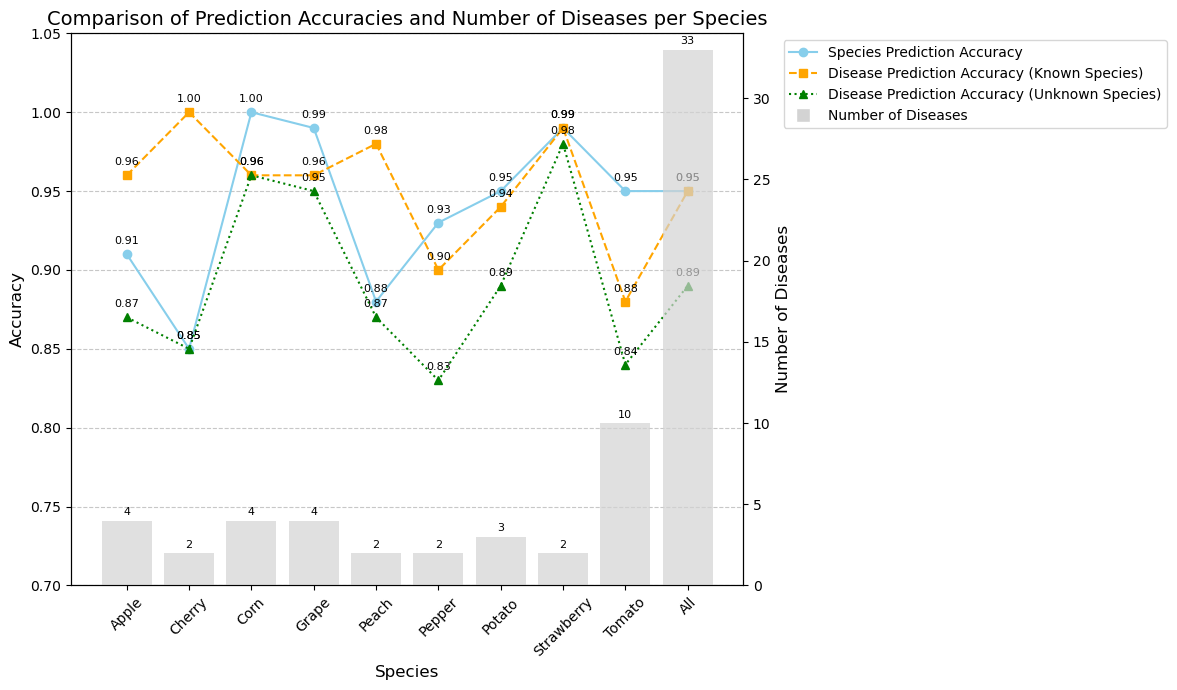

In [96]:
categories = list(accuracies_species_updated.keys())
values_species_updated = list(accuracies_species_updated.values())
values_disease_known_species_updated = list(accuracies_disease_known_species_updated.values())
values_accuracies = list(accuracies.values())

# Number of diseases per species (from the 'diseases' dictionary)
diseases_updated = {}
for species, disease in diseases.items():
    diseases_updated[species.split("_")[0].strip(",")] = disease

all_diseases = [disease for disease_list in diseases.values() for disease in disease_list]
diseases_updated["All"] = list(all_diseases)

num_diseases = [len(diseases_updated[species]) for species in categories]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

line_species = ax1.plot(categories, values_species_updated, marker='o', color='skyblue', label='Species Prediction Accuracy')
for i, value in enumerate(values_species_updated):
    ax1.text(i, value + 0.005, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

line_disease_known = ax1.plot(categories, values_disease_known_species_updated, marker='s', color='orange', label='Disease Prediction Accuracy (Known Species)', linestyle='--')
for i, value in enumerate(values_disease_known_species_updated):
    ax1.text(i, value + 0.005, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

line_accuracies = ax1.plot(categories, values_accuracies, marker='^', color='green', label='Disease Prediction Accuracy (Unknown Species)', linestyle=':')
for i, value in enumerate(values_accuracies):
    ax1.text(i, value + 0.005, f'{value:.2f}', ha='center', va='bottom', fontsize=8)


ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xlabel('Species', fontsize=12)
ax1.set_title('Comparison of Prediction Accuracies and Number of Diseases per Species', fontsize=14)
ax1.set_ylim(0.7, 1.05)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
bars = ax2.bar(categories, num_diseases, color='lightgray', alpha=0.7, label='Number of Diseases')
ax2.set_ylabel('Number of Diseases', fontsize=12)
ax2.set_ylim(0, max(num_diseases) + 1)

for i, value in enumerate(num_diseases):
    ax2.text(i, value + 0.2, str(value), ha='center', va='bottom', fontsize=8)

bars_patch = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgray', markersize=10, label='Number of Diseases')

handles, labels = ax1.get_legend_handles_labels()
handles.extend([bars_patch])  
labels.extend(['Number of Diseases'])  

ax1.legend(handles=handles, labels=labels, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()

plot_filename = "accuracy_comparison_plot.png"
plt.savefig(plot_filename)

plt.show()

In [22]:
plants = {}

for imfolder in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, imfolder)
    if os.path.isdir(folder_path):
        plant = imfolder.strip().split("___")[0].split("_")[0].strip(",")
        if plant in plants:
            plants[plant].append(imfolder)
        else:
            plants[plant] = [imfolder]

categories_label = []

# The class names (folder names) must be encoded to numerical values
for imfolder in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, imfolder)
    if os.path.isdir(folder_path):
        if imfolder not in categories_label:
            categories_label.append(imfolder)

print(len(categories_label))

label_encoder_combined = LabelEncoder()
label_encoder_combined.fit(categories_label)  # Assign a number to each class

with open('label_encoder_all.pkl', 'wb') as file:
      pickle.dump(label_encoder_combined, file)

def image_data(folder, batch_size=32, encoder = label_encoder_combined):
    image_paths = []
    labels = []

    # Collect image paths and labels from all subfolders
    for imfolder in os.listdir(folder): #Go through all folders in the train folder (each folder represents a category)
        folder_path = os.path.join(folder, imfolder)
        if os.path.isdir(folder_path):
            for imfile in os.listdir(folder_path): #Go through all of the files (photos) in the subfolder
                image_path = os.path.join(folder_path, imfile)
                if os.path.isfile(image_path):
                    image_paths.append(image_path)
                    labels.append(imfolder)


# Shuffle the data by shuffling the indexes
    def generator(seed=None):
        if seed is None:
            random.seed(7)

        indices = list(range(len(image_paths)))
        random.shuffle(indices)

        while True:
            # Yield data in batches
            X_batch = []
            y_batch = []

            for i in indices:
                image_path = image_paths[i]
                label = labels[i]

                img = cv2.imread(image_path) #Load in the image data (256x256x3 matrix) with cv2

                if img is not None:
                    if img.shape != (256, 256, 3):
                        img = cv2.resize(img, (256, 256)) #If an image doesnt have the regular size, resize it
                    img = img / 255.0  # Normalize the image to the range [0, 1], because neural networks work better with numbers in this range

                    X_batch.append(img)
                    y_batch.append(label)

                # Full batch
                if len(X_batch) >= batch_size:
                    X_batch = np.array(X_batch) #Convert to numpy array

                    y_batch = encoder.transform(y_batch)  #Convert string labels to integers
                    y_batch = np.array(y_batch)

                    yield X_batch, y_batch

                    X_batch = []
                    y_batch = []

        #All remaining images that aren't part of a full batch
            if X_batch:
                X_batch = np.array(X_batch) #Convert to numpy array

                y_batch = encoder.transform(y_batch)  #Convert string labels to integers
                y_batch = np.array(y_batch)

                yield X_batch, y_batch

    return generator(seed=7), image_paths

test_data, image_paths_test = image_data(test_folder, 32, label_encoder_combined)

# Calculating the number of steps (batches) per epoch
test_steps = int(math.ceil(len(image_paths_test) / 32))

33


In [78]:
test_loss, test_accuracy = model_all.evaluate(
    test_data,
    steps=test_steps_species,
    verbose=1
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.2%}") #Total test accuracy on all images

237/237 ━━━━━━━━━━━━━━━━━━━━ 76s 321ms/step - accuracy: 0.8994 - loss: 0.3462
Test Loss: 0.34766697883605957
Test Accuracy: 89.49%
